In [20]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [21]:
df = pd.read_csv('../Datasets/nyserda-electric-vehicle-drive-clean-rebate-data-beginning-2017-1.csv')

In [22]:
df

,Data through Date,Submitted Date,Make,Model,County,ZIP,EV Type,Transaction Type,Annual GHG Emissions Reductions (MT CO2e),Annual Petroleum Reductions (gallons),Rebate Amount (USD)
0,02/29/2020,01/13/2018,Ford,Focus,Westchester,10598,BEV,Lease,2.76,592.89,1700
1,02/29/2020,09/25/2017,Ford,Focus,Oneida,13601,BEV,Lease,2.76,592.89,1700
2,02/29/2020,04/26/2018,Ford,Focus,Suffolk,11776,BEV,Lease,2.76,592.89,1700
3,02/29/2020,08/30/2017,Ford,Focus,Nassau,11756,BEV,Lease,2.76,592.89,1700
4,02/29/2020,05/29/2018,Ford,Focus,Onondaga,13039,BEV,Purchase,2.76,592.89,1700
...,...,...,...,...,...,...,...,...,...,...,...
23169,02/29/2020,12/27/2017,Volvo,XC60 T8,Onondaga,13039,PHEV,Purchase,0.40,200.58,500
23170,02/29/2020,05/29/2018,Volvo,XC60 T8,Nassau,11791,PHEV,Purchase,0.40,200.58,500
23171,02/29/2020,09/25/2017,Volvo,XC90 T8,Niagara,14094,PHEV,Purchase,0.68,231.77,500
23172,02/29/2020,11/01/2017,Volvo,XC90 T8,Erie,14051,PHEV,Lease,0.68,231.77,500


In [23]:
df = df.drop(columns=["Data through Date", "ZIP"])

In [24]:
df = df.rename(columns={'Annual GHG Emissions Reductions (MT CO2e)': 'Annual CO2 Reductions', 'Annual Petroleum Reductions (gallons)': 'Annual Petroleum Reductions'})

In [25]:
df

,Submitted Date,Make,Model,County,EV Type,Transaction Type,Annual CO2 Reductions,Annual Petroleum Reductions,Rebate Amount (USD)
0,01/13/2018,Ford,Focus,Westchester,BEV,Lease,2.76,592.89,1700
1,09/25/2017,Ford,Focus,Oneida,BEV,Lease,2.76,592.89,1700
2,04/26/2018,Ford,Focus,Suffolk,BEV,Lease,2.76,592.89,1700
3,08/30/2017,Ford,Focus,Nassau,BEV,Lease,2.76,592.89,1700
4,05/29/2018,Ford,Focus,Onondaga,BEV,Purchase,2.76,592.89,1700
...,...,...,...,...,...,...,...,...,...
23169,12/27/2017,Volvo,XC60 T8,Onondaga,PHEV,Purchase,0.40,200.58,500
23170,05/29/2018,Volvo,XC60 T8,Nassau,PHEV,Purchase,0.40,200.58,500
23171,09/25/2017,Volvo,XC90 T8,Niagara,PHEV,Purchase,0.68,231.77,500
23172,11/01/2017,Volvo,XC90 T8,Erie,PHEV,Lease,0.68,231.77,500


In [26]:
df.duplicated().sum()

6147

In [27]:
df = df.drop_duplicates()

In [28]:
df.shape

(17027, 9)

Removing Outliers

In [29]:
cols = ['Annual CO2 Reductions', 'Annual Petroleum Reductions',	'Rebate Amount (USD)']

df[cols] = df[cols].astype('float')

for col in cols:
    quartiles = df[col].quantile([0.2, 0.8])
    q1 = quartiles.loc[0.2]
    q3 = quartiles.loc[0.8]

    low_bound = q1 - 1.5 * (q3 - q1)
    upp_bound = q3 + 1.5 * (q3 - q1)

    df = df[(df[col] >= low_bound) & (df[col] <= upp_bound)]


/var/folders/6g/4zq1d985075_7_l6gxj2n81m0000gn/T/ipykernel_2431/3307687926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].astype('float')


In [30]:
df.shape

(15771, 9)

Formatting Date Column

In [31]:
df[['Submitted Month', 'Submitted Year']] = df["Submitted Date"].apply(lambda x: pd.Series([x.split('/')[0], x.split('/')[2]]))

df = df.drop(columns=["Submitted Date", "Submitted Month"])

Label Encoding Categorical Columns

In [32]:
cols = ["Make", "Model", "EV Type","County","Transaction Type", "Rebate Amount (USD)"]

def label_encode(columns_to_encode):
    for column in columns_to_encode:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

df = label_encode(cols)

Handling Class Imbalance

In [33]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X = df.drop(columns=['Rebate Amount (USD)'])
y = df['Rebate Amount (USD)']
X_smote, y_smote = smote.fit_resample(X, y)

X_smote['Rebate Amount (USD)'] = y_smote

df = X_smote

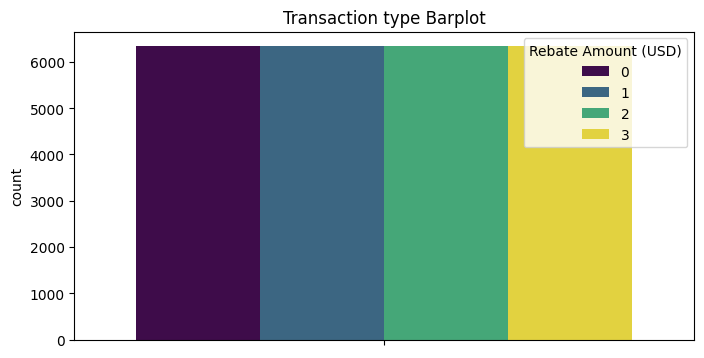

In [34]:
transaction_types = pd.DataFrame(df['Rebate Amount (USD)'].value_counts())

plt.figure(figsize=(8, 4)) 
ax = sns.barplot(y='count', data=transaction_types, palette='viridis', hue='Rebate Amount (USD)')
plt.title('Transaction type Barplot')

plt.show()

Normalizing Variables

In [35]:
columns = [ "Annual CO2 Reductions", "Annual Petroleum Reductions"]
scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])

In [36]:
df

,Make,Model,County,EV Type,Transaction Type,Annual CO2 Reductions,Annual Petroleum Reductions,Submitted Year,Rebate Amount (USD)
0,4,8,59,0,0,0.022884,0.81189,2018.0,2
1,4,8,32,0,0,0.022884,0.81189,2017.0,2
2,4,8,51,0,0,0.022884,0.81189,2018.0,2
3,4,8,29,0,0,0.022884,0.81189,2017.0,2
4,4,8,33,0,1,0.022884,0.81189,2018.0,2
...,...,...,...,...,...,...,...,...,...
25359,6,12,3,0,0,1.562558,0.81189,2019.0,3
25360,13,15,23,0,1,1.562558,0.81189,2019.0,3
25361,2,2,55,0,0,0.890700,0.81189,2019.0,3
25362,10,14,51,0,0,0.442795,0.81189,2019.0,3


In [37]:
df.describe()

,Make,Model,County,EV Type,Transaction Type,Annual CO2 Reductions,Annual Petroleum Reductions,Rebate Amount (USD)
count,25364.000000,25364.000000,25364.000000,25364.000000,25364.000000,2.536400e+04,2.536400e+04,25364.000000
mean,9.021763,14.798573,35.338117,0.484427,0.580074,-5.692410e-16,-4.840789e-16,1.500000
std,4.801193,7.132244,16.271021,0.499767,0.493556,1.000020e+00,1.000020e+00,1.118056
min,0.000000,0.000000,0.000000,0.000000,0.000000,-3.084456e+00,-2.952607e+00,0.000000
25%,5.000000,9.000000,27.000000,0.000000,0.000000,-2.850503e-01,-1.105243e+00,0.750000
50%,12.000000,16.000000,33.000000,0.000000,1.000000,2.288437e-02,8.118897e-01,1.500000
75%,13.000000,21.000000,51.000000,1.000000,1.000000,7.787240e-01,8.118897e-01,2.250000
max,15.000000,28.000000,61.000000,1.000000,1.000000,1.562558e+00,8.118897e-01,3.000000


In [38]:
df.to_csv('../Cleaned Datasets/rebate_cleaned.csv', index=False)